In [283]:
import os
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from wordcloud import WordCloud
import nltk
from dotenv import load_dotenv

# Load the .env file
load_dotenv()
nltk.data.path.append(os.getenv("NLTK_PATH"))
from nltk.corpus import stopwords



#Options

In [284]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Work\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Work\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [285]:
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", lambda x: f"{x :.2f}")
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('french'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','Unknown')



# Connect to the database and create df



In [286]:
con = duckdb.connect('movies.db')

In [287]:
movies = con.table('movies').df()
con.close()

In [288]:
movies.head()

,backdrop_path,id,imdb_id,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,vote_average,vote_count,genres,actors,actors_id,directors,directors_id,video_name,video_key,keywords,production_company
0,/qYHM1QaR86eQeKX8qi8kFtqFAGd.jpg,655363,tt9834506,Post Mortem,"Hongrie, 1919. Miraculeusement revenu du front...",10.79,/4X47HT16UXf96cn1pI2hq31tX31.jpg,2020-10-28,115,Released,Immortalisez vos plus grandes peurs.,Post Mortem,6.72,194,"[Horreur, Mystère, Thriller]","[Viktor Klem, Fruzsina Hais, Judit Schell]","[1739471, 2481242, 125682]",[Péter Bergendy],[930499],[POST MORTEM Bande Annonce VF (2022)],[pv4NBtvy4zw],[],[Szupermodern Stúdió]
1,/dhr0q4eiRr8ltqPig32TwhPRdaD.jpg,17,tt0411267,The Dark,En débarquant dans cette contrée isolée du pay...,24.61,/ebzumprgCpfFUZOTJNZ407FA9IH.jpg,2005-09-28,87,Released,,The Dark,5.80,256,"[Horreur, Thriller, Mystère]","[Maria Bello, Sean Bean, Abigail Stone]","[49, 48, 55]",[John Fawcett],[43],[],[],"[sea, wales, child abuse]","[Constantin Film, Impact Pictures, Isle of Man..."
2,/bQ8fRUaitJvi54O2lUT6Ta7FVHK.jpg,25,tt0418763,Jarhead,"Été 1990. Anthony Swofford, fils et petit‐fils...",66.92,/rpPa7dGWnuldRGyLtr4eT2n38jH.jpg,2005-11-04,123,Released,"La guerre, c’est l’enfer. L’attente, c’est pire.",Jarhead : La Fin de l'innocence,6.64,2751,"[Drame, Guerre]","[Jake Gyllenhaal, Jamie Foxx, Peter Sarsgaard]","[131, 134, 133]",[Sam Mendes],[39],[Jarhead: La fin de l'innocence (VF) - Bande A...,"[3wZjh-2PbIM, peoCGkXCCp4]","[california, gulf war, saudi arabia]","[Red Wagon Entertainment, Neal Street Producti..."
3,/pR12U3MPxq6aeHHd4sQOml72SSH.jpg,98339,tt1867093,The Samaritan,"Foley, un ancien arnaqueur, tente de changer d...",22.38,/5Lvo5OjSZmirakT8B7xxEnn1h1F.jpg,2012-03-02,90,Released,,Le Samaritain,5.40,197,[Thriller],"[Samuel L. Jackson, Luke Kirby, Ruth Negga]","[2231, 7002, 17018]",[David Weaver],[545229],[],[],"[prison, drug use, revenge]","[H2O Motion Pictures, 2262730 Ontario, Middle ..."
4,/8ln5VUVk7gnNGIb2VNgw8nICDVt.jpg,35,tt0462538,The Simpsons Movie,Lorsque Homer pollue gravement le lac de Sprin...,80.27,/9Vz5sgIG10YNka14cv11dO5CfMF.jpg,2007-07-25,88,Released,La plus grande aventure familiale de tous les ...,"Les Simpson, le film",7.01,7718,"[Animation, Comédie, Familial]","[Dan Castellaneta, Julie Kavner, Nancy Cartwri...","[198, 199, 200]",[David Silverman],[197],"[LES SIMPSON - LE FILM (bande-annonce), Interv...","[8arbBxezySc, Ji32yfWuROQ]","[garbage, pollution, quarantine]","[Gracie Films, 20th Century Fox]"


# Start EDA

In [289]:
movies.describe()



,id,popularity,release_date,runtime,vote_average,vote_count
count,8675.00,8675.00,8675,8675.00,8675.00,8675.00
mean,314387.45,41.40,2015-01-02 00:31:52.253602,105.15,6.53,1504.14
min,17.00,0.60,2004-05-13 00:00:00,0.00,5.00,150.00
25%,47808.50,19.08,2010-10-22 00:00:00,93.00,6.00,245.00
50%,291081.00,26.71,2015-07-25 00:00:00,102.00,6.50,477.00
75%,504299.00,41.73,2019-03-30 00:00:00,114.00,7.06,1351.50
max,1226841.00,2040.25,2024-05-02 00:00:00,247.00,9.10,35657.00
std,273179.77,63.94,NaN,18.24,0.72,2844.58


In [290]:
movies.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   backdrop_path       8671 non-null   object        
 1   id                  8675 non-null   int32         
 2   imdb_id             8674 non-null   object        
 3   original_title      8675 non-null   object        
 4   overview            8675 non-null   object        
 5   popularity          8675 non-null   float64       
 6   poster_path         8675 non-null   object        
 7   release_date        8675 non-null   datetime64[us]
 8   runtime             8675 non-null   int32         
 9   status              8675 non-null   object        
 10  tagline             8675 non-null   object        
 11  title               8675 non-null   object        
 12  vote_average        8675 non-null   float64       
 13  vote_count          8675 non-null   int32       

In [291]:
movies['vote_count'].describe()




count    8675.00
mean     1504.14
std      2844.58
min       150.00
25%       245.00
50%       477.00
75%      1351.50
max     35657.00
Name: vote_count, dtype: float64

In [292]:
movies['vote_average'].describe()



count   8675.00
mean       6.53
std        0.72
min        5.00
25%        6.00
50%        6.50
75%        7.06
max        9.10
Name: vote_average, dtype: float64

In [293]:
c = movies['vote_average'].mean()
c

6.53053371757925

In [294]:
#m= movies['vote_count'].quantile(0.5)
m = 150

In [295]:
def weighted_rating(df: pd.DataFrame,m: int=m, c: float=c)->float:
    v = df['vote_count']
    r = df['vote_average']
    return (v / (v+m)) * r + (m / (v+m)) * c



In [296]:
movies['imdb_score'] = movies.apply(weighted_rating, axis=1)

movies_sort_score = movies.sort_values(by='imdb_score', ascending=False)
movies_sort_score[['title','imdb_score','popularity','vote_count','vote_average']].head(10)




,title,imdb_score,popularity,vote_count,vote_average
46,The Dark Knight : Le Chevalier noir,8.51,138.69,31879,8.52
1257,Parasite,8.49,106.48,17489,8.51
3430,Your Name.,8.47,112.28,10944,8.50
7341,Interstellar,8.42,396.85,34251,8.43
8108,Spider-Man : New Generation,8.38,139.78,14962,8.40
1310,Le Château ambulant,8.37,110.24,9418,8.40
7556,Inception,8.36,380.39,35657,8.37
4770,Whiplash,8.36,219.93,14584,8.38
3553,Spider-Man : Across the Spider-Verse,8.33,250.44,6221,8.37
5337,Silent Voice,8.31,59.87,3774,8.38


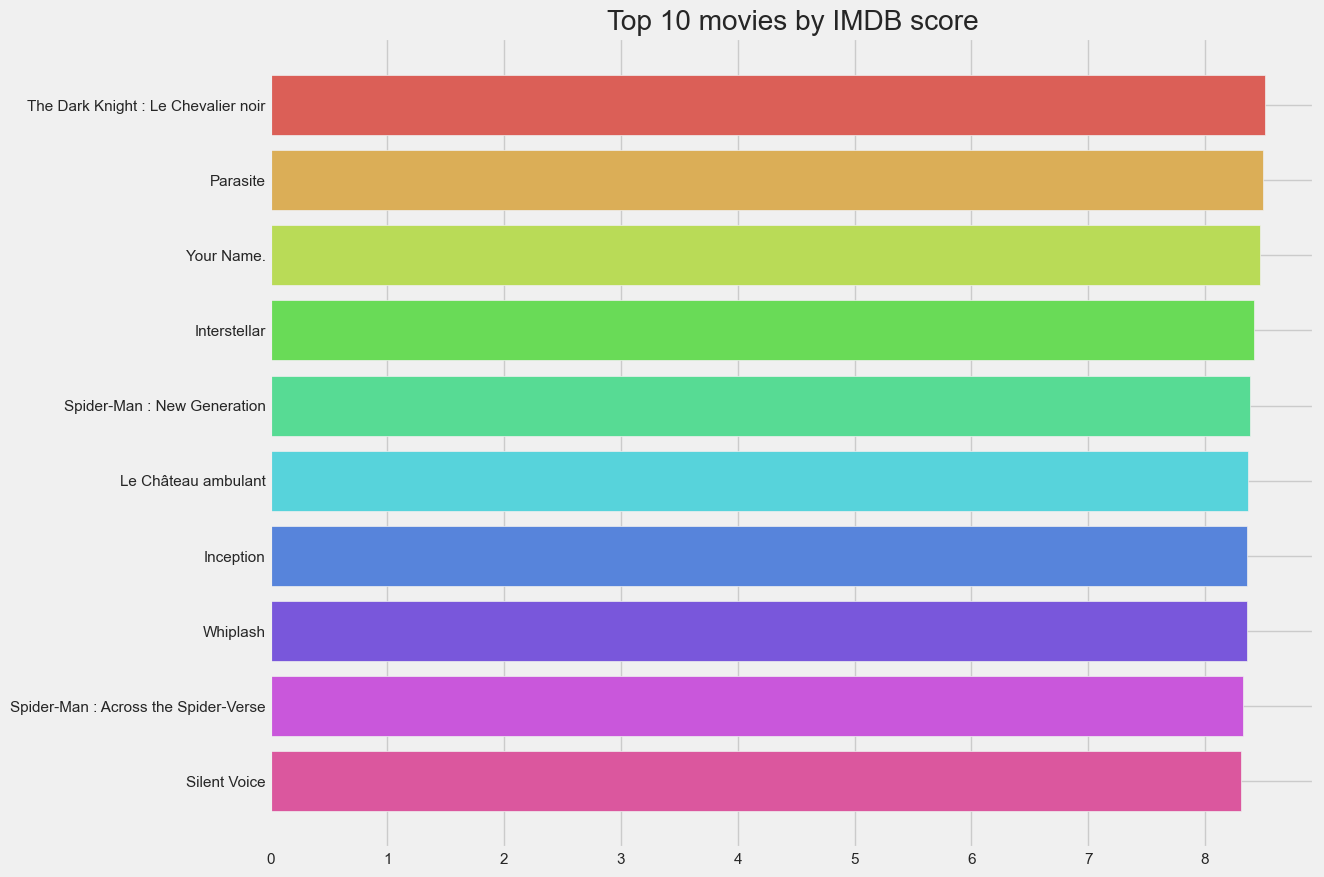

In [297]:
plt.subplots(figsize=(12,10))
plt.barh(movies_sort_score['title'].head(10),movies_sort_score['imdb_score'].head(10),color=sns.color_palette('hls',10))
plt.gca().invert_yaxis()
plt.title('Top 10 movies by IMDB score')
plt.show()



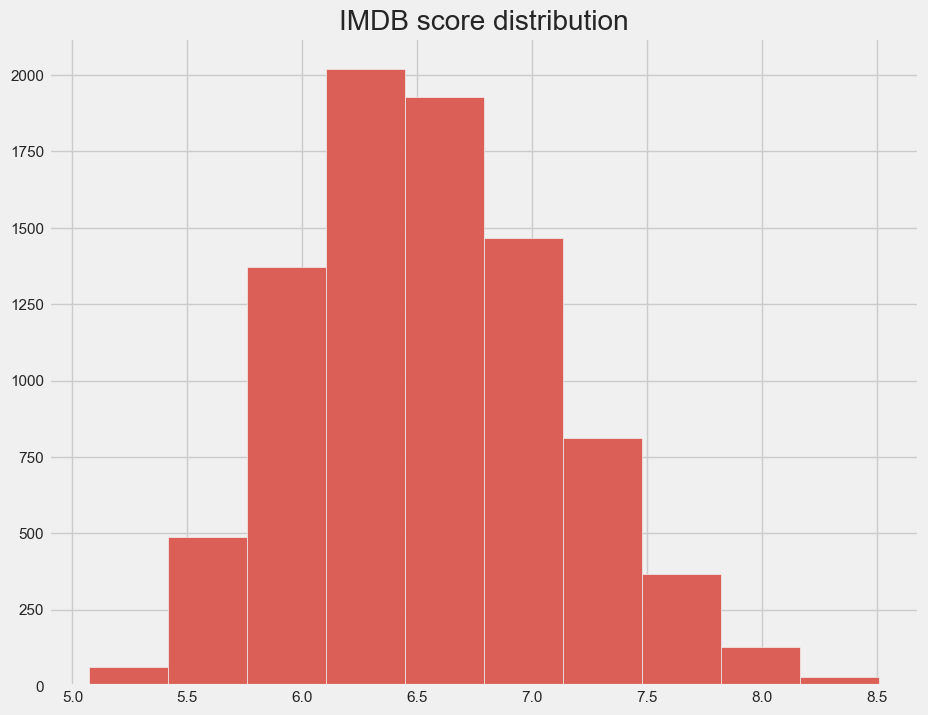

In [298]:
plt.subplots(figsize=(10,8))
plt.hist(movies['imdb_score'],bins=10,color=sns.color_palette('hls',1))
plt.title('IMDB score distribution')
plt.show()




In [299]:
#movies.to_parquet('streamlit/data/movies.parquet')

# overview/tagline. trying out TF-IDF


In [300]:
#Define a TF-IDF Vectorizer Object. Remove all french stop words
tfidf = TfidfVectorizer(stop_words=list(stop_words), lowercase=True)



In [301]:
#add tagline to overview
movies['tagline'] = movies['tagline'].fillna('')
movies['overview'] = movies['overview'].replace('','Missing')
movies['description'] = movies['overview'] +' ' + movies['tagline']
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(8675, 35125)

In [302]:
combined_features2 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
print(combined_features2.shape)



(8675, 35125)


In [303]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [304]:
#Construct a reverse map of index and movie titles
index = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [305]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(id, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    #idx = index[title]
    idx = movies.index[movies['id'] ==id][0]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return (movies['title'].iloc[movie_indices],movies['id'].iloc[movie_indices])

In [306]:
movies2 = movies[['title','genres','actors','directors','keywords']]



# Genres columns

In [307]:
movies2['genres'] = movies2['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies2['genres'] = movies2['genres'].str.split(',')



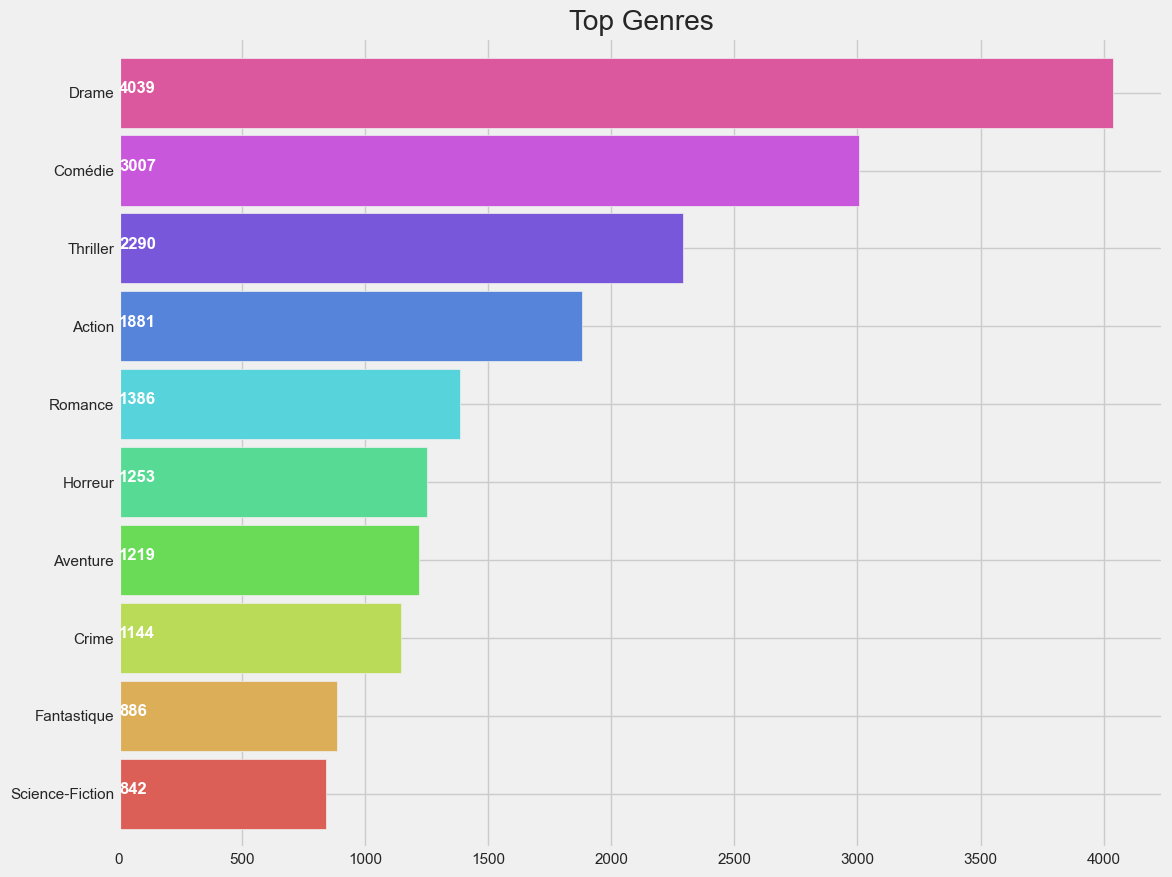

In [308]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movies2['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(0.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

# Actors columns

In [309]:
movies2['actors'] = movies2['actors'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies2['actors'] = movies2['actors'].str.split(',')



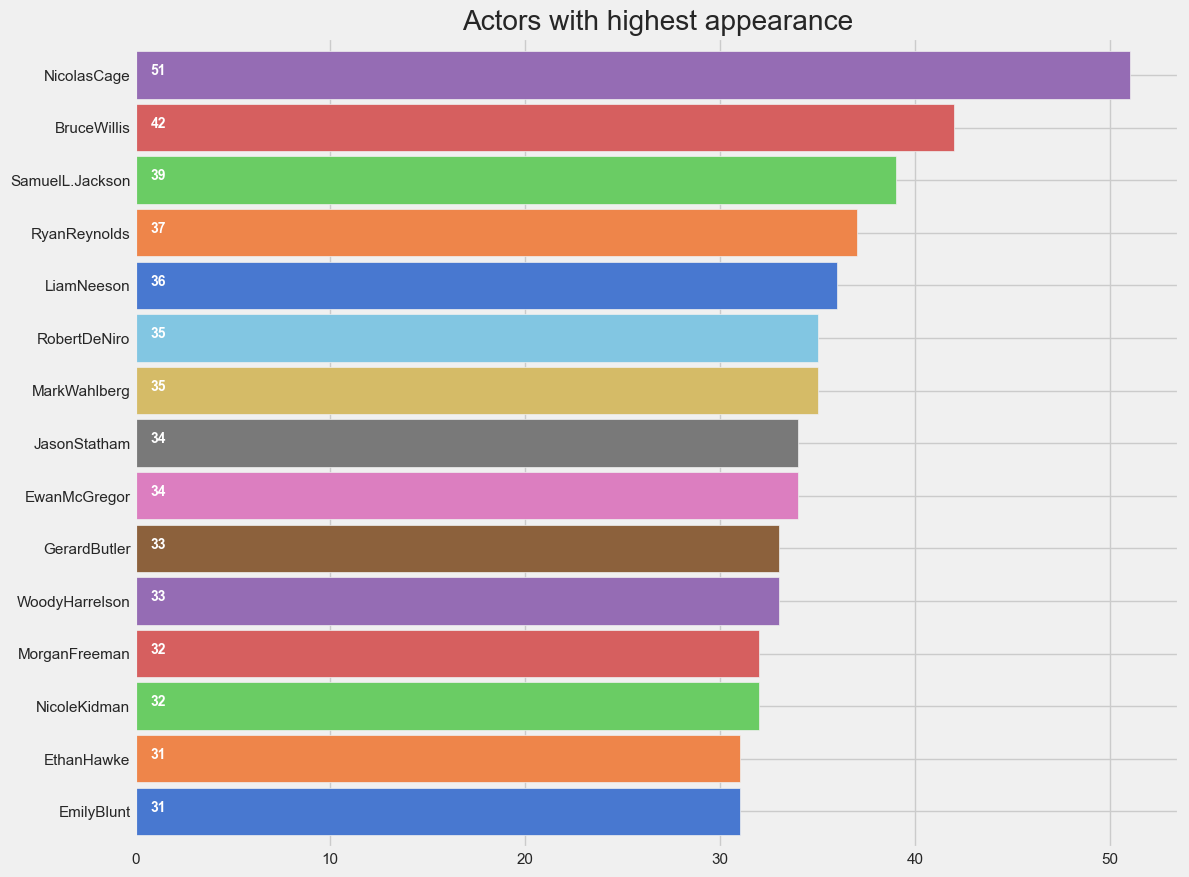

In [310]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies2['actors']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

# directors column

In [311]:
movies2['directors'] = movies2['directors'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies2['directors'] = movies2['directors'].str.split(',')



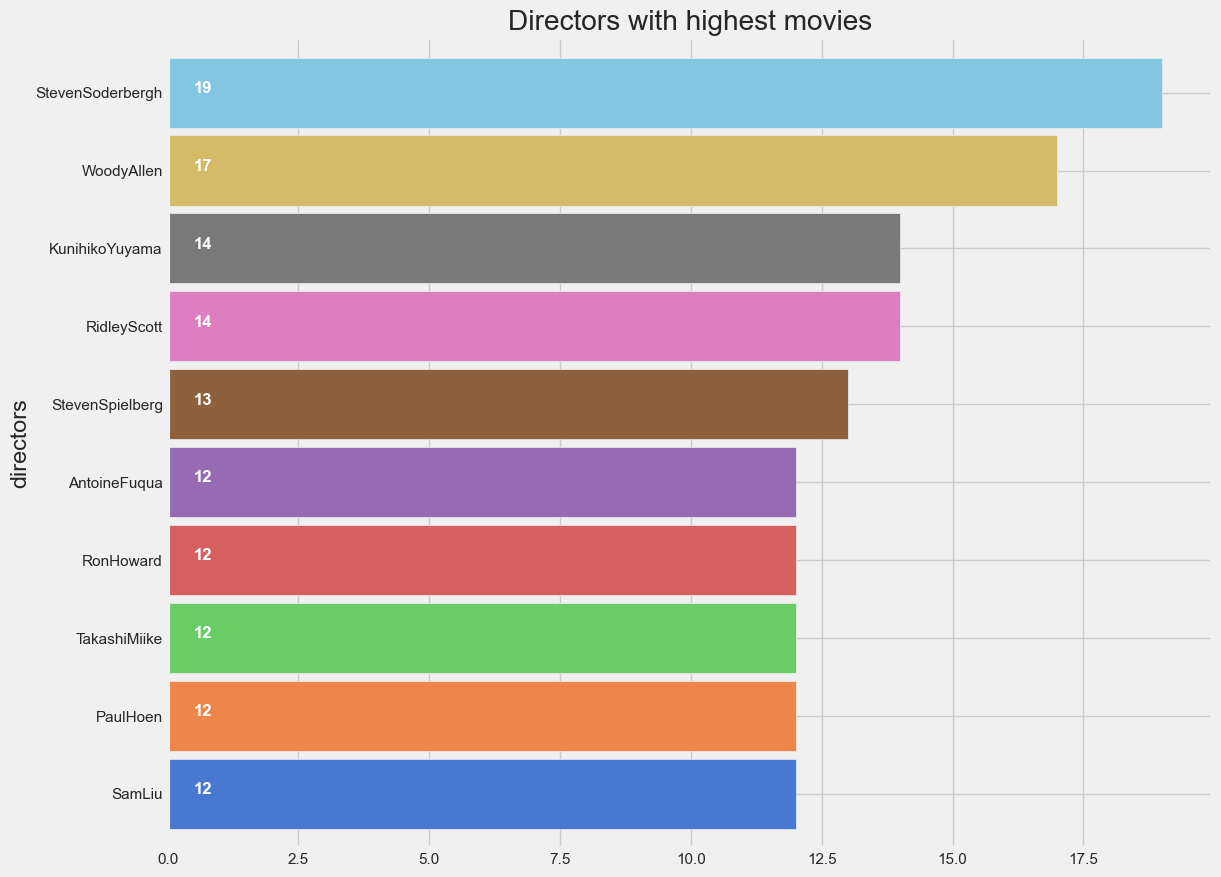

In [312]:
plt.subplots(figsize=(12,10))
filtered_movies = movies2[(movies2['directors'] != '') & (~movies2['directors'].apply(lambda x: 'Unknown' in x))]
ax = filtered_movies.explode('directors')['directors'].value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(filtered_movies.explode('directors')['directors'].value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

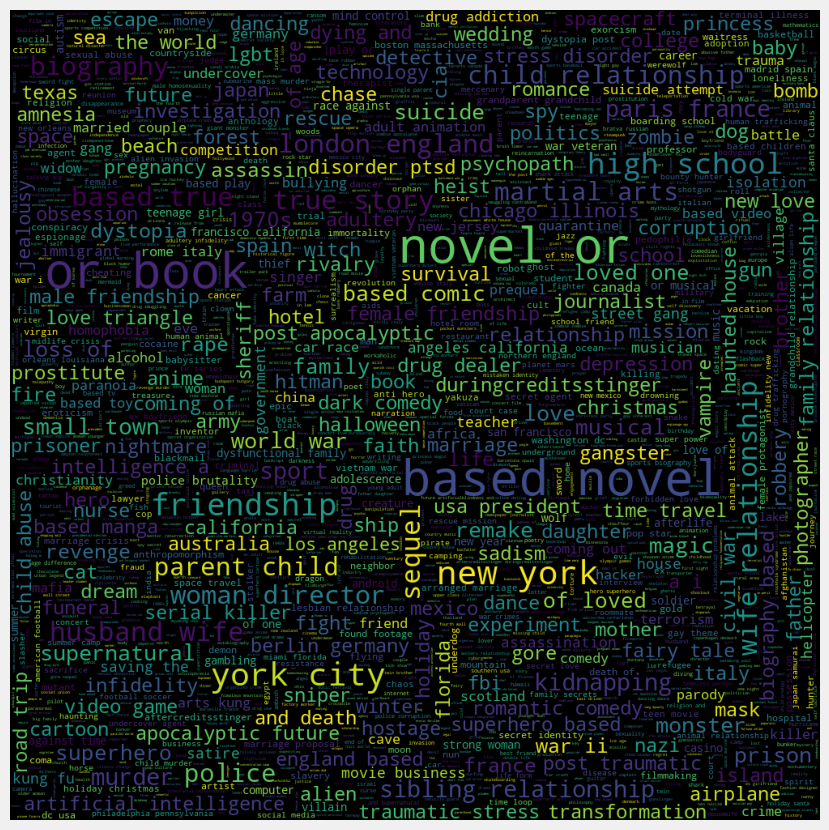

In [313]:
plt.subplots(figsize=(12,12))


words=movies2['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=stop_words, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

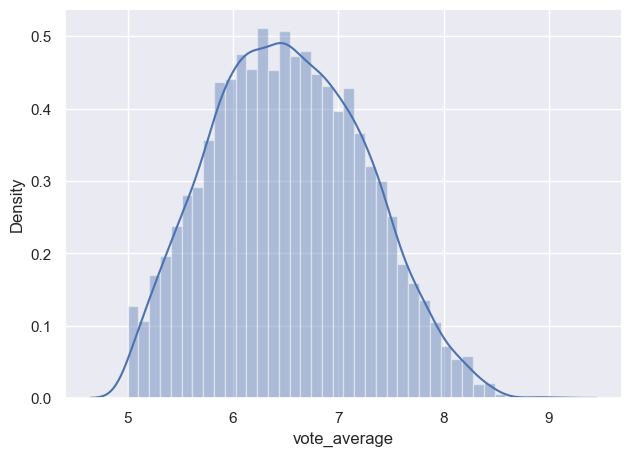

In [314]:
sns.set(color_codes=True)
sns.distplot(movies["vote_average"], );



In [315]:
liste_title = movies['title'].tolist()

In [316]:
random_title_choice = np.random.choice(liste_title)
#random_title_choice = 'Babysitting 2'
print(random_title_choice)

Free Dance


In [317]:
row = movies[movies['title'] == random_title_choice]
print(row.index[0])


6352


In [318]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''




In [319]:
features = ['actors', 'keywords', 'directors', 'genres', 'production_company']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [320]:
def create_mix(x):
    return ''.join(x['keywords']) + ' ' + ''.join(x['actors']) + ' ' + x['directors'] + ' ' + ''.join(x['genres']) + ' ' + ''.join(x['production_company'])
movies['mixed'] = movies.apply(create_mix, axis=1)
#+ ' ' + ' '.join(x['description'])


In [321]:
movies['popularity_log'] = np.log1p(movies['popularity'])

In [339]:
columns_tfidf_to_encode = 'description'
columns_to_countvectorize = 'mixed'
columns_to_std = ['imdb_score','vote_average']



In [340]:
tfidf_transformers = [
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words), lowercase=True), columns_tfidf_to_encode)
]
count_transformers = [
    ('count', CountVectorizer(stop_words=list(stop_words), lowercase=True), columns_to_countvectorize)
]
std_scale_transformers = [
    ('std_scale', StandardScaler(), columns_to_std)
]



In [341]:
all_transformers =count_transformers + std_scale_transformers + tfidf_transformers



In [342]:
preprocessor = ColumnTransformer(all_transformers)
preprocessor

ColumnTransformer(transformers=[('count',
                                 CountVectorizer(stop_words=['aviez', 'êtes',
                                                             ',', 'étante', 'j',
                                                             'fus', 'aux',
                                                             'eurent', 'un',
                                                             'fut', '!', 'te',
                                                             'suis', 'du',
                                                             'soyez', 'avons',
                                                             'eussions',
                                                             'étaient', 'k',
                                                             'serions', 'eus',
                                                             'vous', 'eussent',
                                                             'aura', 'vos',
                                                             'eues', 'étais',
                                                             'fussiez', ' ',
                                                             'aurons', ...]),
                                 'mixed'),
                                ('std_scale', StandardScaler(),
                                 ['imdb_score', 'vote_average']),
                                ('tfidf',
                                 TfidfVectorizer(stop_words=['aviez', 'êtes',
                                                             ',', 'étante', 'j',
                                                             'fus', 'aux',
                                                             'eurent', 'un',
                                                             'fut', '!', 'te',
                                                             'suis', 'du',
                                                             'soyez', 'avons',
                                                             'eussions',
                                                             'étaient', 'k',
                                                             'serions', 'eus',
                                                             'vous', 'eussent',
                                                             'aura', 'vos',
                                                             'eues', 'étais',
                                                             'fussiez', ' ',
                                                             'aurons', ...]),
                                 'description')])

In [326]:
# Example of manually applying a transformer to check output shape
transformer = TfidfVectorizer(stop_words=list(stop_words), lowercase=True)
sample_data = movies['description'].head()  # Assuming 'description' is a column
transformed_data = transformer.fit_transform(sample_data)
print(transformed_data.shape)  # Should be (n_samples, n_features)

(5, 227)


In [343]:


# Define the KNN model
knn_model = NearestNeighbors(n_neighbors=11, algorithm="auto")

# Combine preprocessing and KNN model using Pipeline
pipeline_with_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn_model)
])
pipeline_with_knn.fit(movies)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('count',
                                                  CountVectorizer(stop_words=['aviez',
                                                                              'êtes',
                                                                              ',',
                                                                              'étante',
                                                                              'j',
                                                                              'fus',
                                                                              'aux',
                                                                              'eurent',
                                                                              'un',
                                                                              'fut',
                                                                              '!',
                                                                              'te',
                                                                              'suis',
                                                                              'du',
                                                                              'soyez',
                                                                              'avons',
                                                                              'eussions',
                                                                              'étaient',
                                                                              'k',
                                                                              'serions',
                                                                              'eus',
                                                                              'vous',
                                                                              'eussent',
                                                                              'aura',
                                                                              'vos',
                                                                              'eues',
                                                                              'étais',
                                                                              'fussiez',
                                                                              ' ',
                                                                              'aurons', ...]),
                                                  'mixed'),
                                                 ('std_scale', StandardScaler(),
                                                  ['imdb_score',
                                                   'vote_average']),
                                                 ('tfidf',
                                                  TfidfVectorizer(stop_words=['aviez',
                                                                              'êtes',
                                                                              ',',
                                                                              'étante',
                                                                              'j',
                                                                              'fus',
                                                                              'aux',
                                                                              'eurent',
                                                                              'un',
                                                                              'fut',
                                                                              '!',
                                                  

In [349]:
def find_nearest_neighbors(title : int, pipeline_with_knn : Pipeline, movies : pd.DataFrame) -> pd.DataFrame :
 
    df = movies[['mixed', 'imdb_score', 'vote_average','id','title', 'description']]
    # Filter the DataFrame to get the features of the specified product
    query_product_features = df[df['id'] == title].drop(columns=['id'])
    # Use the pipeline to preprocess the query product features
    query_product_features_processed = pipeline_with_knn.named_steps['preprocessor'].transform(query_product_features)

    # Use the KNN model to find the nearest neighbors for the query product
    nearest_neighbors_indices = pipeline_with_knn.named_steps['knn'].kneighbors(query_product_features_processed)[1][0]

    # Get the nearest neighbors' Product_IDs
    nearest_neighbors_product_ids = df.iloc[nearest_neighbors_indices]['id']

    # Create a DataFrame containing the nearest neighbors' information
    nearest_neighbors_df = df[df['id'].isin(nearest_neighbors_product_ids)]

    return nearest_neighbors_df[nearest_neighbors_df['id'] != title],

# Example usage:
query_product_id = 49026 # Specify the Product_ID of the query product
nearest_neighbors_df = find_nearest_neighbors(query_product_id, pipeline_with_knn, movies)

nearest_neighbors_df

(                                                  mixed  imdb_score  \
 46    [joker,sadism,chaos] [christianbale,heathledge...        8.51   
 93    [martialarts,undercover,lossoflovedone] [chris...        7.70   
 302   [dyinganddeath,suicide,classsociety] [hughjack...        8.18   
 3547  [] [annabethgish,warrenchristie,lauraharris] [...        7.30   
 4375  [army,beach,france] [fionnwhitehead,tomhardy,m...        7.44   
 4752  [] [vincentcassel,ludivinesagnier,mathieuamalr...        7.18   
 6082  [assassin,espionage,spy] [johndavidwashington,...        7.17   
 6589  [drugdealer,basedonnovelorbook,ambulance] [ben...        7.19   
 8135  [] [williamlevy,aliciasanz,robertososa] [matía...        7.52   
 8439  [] [andreacarpenzano,arturobruni] [unknown] [c...        7.10   
 
       vote_average      id                                              title  \
 46            8.52     155                The Dark Knight : Le Chevalier noir   
 93            7.71     272               

In [329]:
count = CountVectorizer(stop_words=list(stop_words))
count_matrix = count.fit_transform(movies['mixed'])



In [330]:
scaler = StandardScaler()
#numerical_columns = ['imbd_score', 'popularity_log', 'vote_average']
numerical_columns = ['imdb_score', 'vote_average']
numerical_features = scaler.fit_transform(movies[numerical_columns])



In [331]:
# Concatenate text and numerical features
#combined_features2 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
#combined_features = pd.DataFrame(count_matrix.toarray(), columns=count.get_feature_names_out())
#combined_features[numerical_columns] = numerical_features

In [332]:
# Assuming numerical_columns is a list of column names for the numerical data
combined_features2 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
combined_features = pd.DataFrame(count_matrix.toarray(), columns=count.get_feature_names_out())
numerical_features_df = pd.DataFrame(numerical_features, columns=numerical_columns)

In [333]:
print(combined_features2.shape)
print(combined_features.shape)
print(numerical_features_df.shape)

# If all shapes have the same number of rows, proceed to concatenate
if combined_features2.shape[0] == combined_features.shape[0] == numerical_features_df.shape[0]:
    final_features = pd.concat([combined_features2, combined_features, numerical_features_df], axis=1)
else:
    print("Error: DataFrames do not have the same number of rows")

(8675, 35125)
(8675, 28563)
(8675, 2)


In [334]:
cosine_sim2 = cosine_similarity(final_features, final_features)



In [335]:
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

In [336]:
average_cosine_sim = (cosine_sim + cosine_sim2) / 2
get_recommendations(99861, average_cosine_sim)



(6904                                  Avengers
 6344                           Thor : Ragnarok
 1221                        Avengers : Endgame
 890                                 Iron Man 3
 2934                                Iron Man 2
 622     Captain America : Le Soldat de l'hiver
 1222                   Avengers : Infinity War
 2465               Captain America : Civil War
 504                                   Iron Man
 6328         Les Gardiens de la Galaxie Vol. 2
 Name: title, dtype: object,
 6904     24428
 6344    284053
 1221    299534
 890      68721
 2934     10138
 622     100402
 1222    299536
 2465    271110
 504       1726
 6328    283995
 Name: id, dtype: int32)

In [348]:
get_recommendations(49026, cosine_sim2)



(46      The Dark Knight : Le Chevalier noir
 93                            Batman Begins
 302                             Le Prestige
 7556                              Inception
 5125                                  Joker
 7341                           Interstellar
 4375                              Dunkerque
 406                           Les Infiltrés
 4675                              Prisoners
 6023                            Oppenheimer
 Name: title, dtype: object,
 46         155
 93         272
 302       1124
 7556     27205
 5125    475557
 7341    157336
 4375    374720
 406       1422
 4675    146233
 6023    872585
 Name: id, dtype: int32)

In [338]:
get_recommendations(99861)



(622     Captain America : Le Soldat de l'hiver
 2934                                Iron Man 2
 4482         Next Avengers: Heroes of Tomorrow
 1640      Iron Man : L'Attaque des Technovores
 6335          Phinéas et Ferb : Mission Marvel
 6047                   Spider-Man : Homecoming
 1221                        Avengers : Endgame
 890                                 Iron Man 3
 8227                              Planète Hulk
 754                        Ant-Man et la Guêpe
 Name: title, dtype: object,
 622     100402
 2934     10138
 4482     14613
 1640    169934
 6335    284019
 6047    315635
 1221    299534
 890      68721
 8227     30675
 754     363088
 Name: id, dtype: int32)